In [1]:
from transformers import AutoTokenizer, BertModel,  AdamW, get_linear_schedule_with_warmup

tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract")

bertmodel = BertModel.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract", return_dict=True)

2022-04-03 15:27:06.440837: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-03 15:27:06.440931: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializi

In [41]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import shutil, sys 
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torchmetrics.functional import accuracy, f1, auroc
from tqdm import tqdm

In [3]:
# load in the data
train = pd.read_csv('data/train.csv')
print(train.shape)
train = train.dropna(subset=['title', 'abstract']).reset_index()
train["alltext"] = train["title"] + " "+ train["abstract"]
print(train.shape)
valid = pd.read_csv('data/valid.csv')
valid = valid.dropna(subset=['title', 'abstract']).reset_index()
valid["alltext"] = valid["title"] + " "+ valid["abstract"]

(52419, 14)
(36052, 16)


In [47]:
    map_labels = {'Case Report': 0,
              'Diagnosis': 1,
              'Epidemic Forecasting': 2,
              'General Info': 3,
              'Mechanism': 4,
              'Prevention': 5,
              'Transmission': 6,
              'Treatment': 7,
              '': 8}

In [4]:
def get_labels_vect(df):
    df = df.fillna('')

    map_labels = {'Case Report': 0,
              'Diagnosis': 1,
              'Epidemic Forecasting': 2,
              'General Info': 3,
              'Mechanism': 4,
              'Prevention': 5,
              'Transmission': 6,
              'Treatment': 7,
              '': 8}

    label_vec_idx = list()

    for i in range(len(df)):
    
        labels = df.loc[i, 'label'].split(';')
        label_vec_idx.append(list(map(map_labels.get, labels)))

    label_vec = [[0]*9 for i in range(len(label_vec_idx))]

    for i in range(len(label_vec_idx)):
        for j in label_vec_idx[i]:
            label_vec[i][j] = 1
        
    df['label_vec'] = label_vec
    return(df)

In [5]:
train = get_labels_vect(train)
valid = get_labels_vect(valid)

In [6]:
encoding = tokenizer.encode_plus(
  train["alltext"][1],
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [7]:
token_counts = []
for _, row in train.iterrows():
  token_count = len(tokenizer.encode(
    row["alltext"], 
    max_length=512, 
    truncation=True
  ))
  token_counts.append(token_count)
# tokenizing with respect to PubMedBERT

(array([ 623., 1814., 3439., 4741., 5148., 5294., 5239., 4139., 2507.,
        3108.]),
 array([ 13. ,  62.9, 112.8, 162.7, 212.6, 262.5, 312.4, 362.3, 412.2,
        462.1, 512. ]),
 <BarContainer object of 10 artists>)

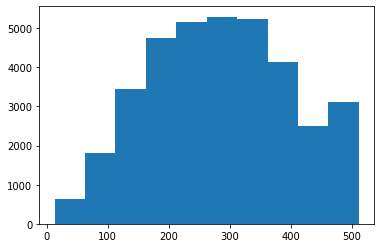

In [8]:
import matplotlib.pyplot as plt
plt.hist(token_counts)

In [9]:
# creating a class for this
class TokensinDataset(Dataset):
    def __init__(
        self, 
        data: pd.DataFrame, 
        tokenizer: tokenizer, 
        max_token_len: int = 512
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        alltext = data_row["alltext"]
        labels = data_row["label_vec"]

        encoding = self.tokenizer.encode_plus(
            alltext,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt')
        return dict(
            alltext=alltext,
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            labels=torch.FloatTensor(labels))

In [10]:
train_dataset = TokensinDataset(
    train,
    tokenizer,
    max_token_len=512
)
valid_dataset = TokensinDataset(
    valid,
    tokenizer,
    max_token_len=512
)

In [11]:
sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['alltext', 'input_ids', 'attention_mask', 'labels'])

In [12]:
sample_item["alltext"]

'[Renin-Angiotensin-System (RAS) and COVID-19 - On The Prescription of RAS Blockers]. Twenty years ago, an enzyme homologous to the previously known angiotensin-converting enzyme (ACE) was identified, and subsequently named ACE2. In the renin-angiotensin system (RAS), ACE2 has counter-regulatory functions against the classical effector peptide angiotensin II, for example in blood pressure regulation and cardiovascular remodeling. However, ACE2 provides an initially unexpected interesting link between virology and cardiovascular medicine. That is, ACE2 represents the binding receptor for the cellular uptake of SARS-CoV and SARS-CoV-2 viruses. Thus, ACE2 is relevant for COVID-19. In this context, it was suspected that therapy with RAS blockers might promote transmission and complications of COVID-19 by upregulation of ACE2 expression. The aim of this short review is, to describe the link between the RAS, particularly ACE2, and COVID-19. Based on our analysis and evaluation of the availab

In [13]:
sample_item["labels"]

tensor([0., 0., 0., 0., 1., 0., 0., 1., 0.])

In [14]:
sample_item["input_ids"].shape

torch.Size([512])

In [15]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=4, num_workers=0)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([4, 512]), torch.Size([4, 512]))

In [16]:
output = bertmodel(sample_batch["input_ids"], sample_batch["attention_mask"])

In [17]:
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([4, 512, 768]), torch.Size([4, 768]))

In [18]:
# to load our data
class textDataModule(pl.LightningDataModule):

    def __init__(self, train_df, test_df, tokenizer, batch_size=32, max_token_len=512):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        self.train_dataset = TokensinDataset(
            self.train_df,
            self.tokenizer,
            self.max_token_len
        )

        self.test_dataset = TokensinDataset(
            self.test_df,
            self.tokenizer,
            self.max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=6
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=6
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=6
        )

In [19]:
N_EPOCHS = 1
BATCH_SIZE = 64

data_module = textDataModule(
  train,
  valid,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=512
)

## Optimizer Scheduler

So people apparently use this to get better results. This is a variable/changing optimizer that adjusts learning rate over time. 


In [20]:
dummy_model = nn.Linear(2, 1)

optimizer = AdamW(params=dummy_model.parameters(), lr=0.001) # this apparently is going to be deprecated soon
# should use torch.optim.AdamW instead... but meh

warmup_steps = 10
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
  optimizer, 
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])

/home/max/python/AML/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


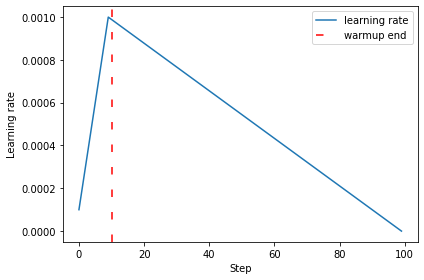

In [21]:
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

In [22]:
steps_per_epoch=len(train) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = total_training_steps // 4
warmup_steps, total_training_steps


(140, 563)

In [23]:
# runnin our data
class DatasetLabeler(pl.LightningModule):

    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = bertmodel
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)        
        loss = 0
        if labels is not None:
                loss = self.criterion(output, labels)
        return loss, output

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": outputs, "labels": labels}

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def training_epoch_end(self, outputs):
        
        labels = []
        predictions = []
        for output in outputs:
            for out_labels in output["labels"].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output["predictions"].detach().cpu():
                predictions.append(out_predictions)

        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)
        map_labels = {'Case Report': 0,
              'Diagnosis': 1,
              'Epidemic Forecasting': 2,
              'General Info': 3,
              'Mechanism': 4,
              'Prevention': 5,
              'Transmission': 6,
              'Treatment': 7,
              '': 8}
        LABEL_COLUMNS = map_labels.keys()
        for i, name in enumerate(LABEL_COLUMNS):
            class_roc_auc = auroc(predictions[:, i], labels[:, i])
            self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)


    def configure_optimizers(self):
        # set up our optimizer
        optimizer = AdamW(self.parameters(), lr=2e-5)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps
        )

        return dict(
            optimizer=optimizer,
            lr_scheduler=dict(
                scheduler=scheduler,
                interval='step'
            )
        )

In [26]:
trainer = pl.Trainer(
    enable_checkpointing=checkpoint_callback,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
    max_epochs=1,
    enable_progress_bar=True,
    
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Running on a subset of the Dataset

In [35]:
test_dat_mod = textDataModule(
  train.head(200),
  valid.head(50),
  tokenizer,
  batch_size=32,
  max_token_len=512
)
spe=len(train.head(200)) // BATCH_SIZE
tts = spe * N_EPOCHS
ws = tts // 4
testmodel = DatasetLabeler(
      n_classes=9,
      n_warmup_steps=ws,
      n_training_steps=tts 
)
trainer.fit(testmodel, test_dat_mod)


  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 109 M 
1 | classifier | Linear    | 6.9 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.957   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/home/max/python/AML/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1938: PossibleUserWarning: The number of training samples (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 13it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [45]:
valid_dataset = TokensinDataset(
    valid.head(50),
    tokenizer,
    max_token_len=512
)
device = torch.device('cpu')
trained_model = trained_model.to(device)

predictions = []
labels = []

for item in tqdm(valid_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()


100%|████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  2.00it/s]


In [46]:
THRESHOLD = .5
accuracy(predictions, labels, threshold=THRESHOLD)

tensor(0.6778)

In [48]:
print("AUROC per tag")
for i, name in enumerate(map_labels.keys()):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

AUROC per tag
Case Report: 0.6530611515045166
Diagnosis: 0.4195803999900818
Epidemic Forecasting: 0.0
General Info: 0.0
Mechanism: 0.7412280440330505
Prevention: 0.5294117331504822
Transmission: 0.06122446060180664
Treatment: 0.6362179517745972
: 0.6976744532585144


/home/max/python/AML/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


In [50]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(
  y_true, 
  y_pred, 
  target_names=map_labels.keys()warmup_steps, total_training_steps, 
  zero_division=0
))

                      precision    recall  f1-score   support

         Case Report       0.03      1.00      0.06         1
           Diagnosis       0.00      0.00      0.00        11
Epidemic Forecasting       0.00      0.00      0.00         0
        General Info       0.00      0.00      0.00         0
           Mechanism       0.39      0.92      0.55        12
          Prevention       0.40      0.12      0.19        16
        Transmission       0.00      0.00      0.00         1
           Treatment       0.50      0.04      0.08        24
                           0.00      0.00      0.00         7

           micro avg       0.15      0.21      0.17        72
           macro avg       0.15      0.23      0.10        72
        weighted avg       0.32      0.21      0.16        72
         samples avg       0.10      0.20      0.13        72



## Running this on the actual full datasets

In [98]:
N_EPOCHS = 1
BATCH_SIZE = 64

steps_per_epoch=len(train) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = total_training_steps // 4
warmup_steps, total_training_steps

data_module = textDataModule(
  train,
  valid,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=512
)

finmodel = DatasetLabeler(
      n_classes=9,
      n_warmup_steps=warmup_steps,
      n_training_steps=total_training_steps 
)


In [99]:
warmup_steps, total_training_steps

(140, 563)

In [100]:
trainerf = pl.Trainer(
    enable_checkpointing=checkpoint_callback,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
    max_epochs=N_EPOCHS,
    enable_progress_bar=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [101]:
trainerf.fit(finmodel, data_module)

/home/max/python/AML/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 109 M 
1 | classifier | Linear    | 6.9 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
6.9 K     Trainable params
109 M     Non-trainable params
109 M     Total params
437.957   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Training: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [105]:
ftrained_model = DatasetLabeler.load_from_checkpoint(
  trainerf.checkpoint_callback.best_model_path,
  n_classes=9
) #saved model stored from best_model_path
ftrained_model.eval()
ftrained_model.freeze()

In [106]:
device = torch.device('cpu')
ftrained_model = ftrained_model.to(device)

predictions = []
labels = []
test = pd.read_csv('data/test.csv')
test = test.dropna(subset=['title', 'abstract']).reset_index()
test["alltext"] = test["title"] + " "+ test["abstract"]
test = get_labels_vect(test)
test_dataset = TokensinDataset(
    test,
    tokenizer,
    max_token_len=512
)


In [107]:
for item in tqdm(test_dataset):
  _, prediction = ftrained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

100%|████████████████████████████████████████████████████████████████| 5617/5617 [43:40<00:00,  2.14it/s]


In [121]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

## playing around with THRESHOLD
THRESHOLD=0.3

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(
  y_true, 
  y_pred, 
  target_names=map_labels.keys(), 
  zero_division=0
))

                      precision    recall  f1-score   support

         Case Report       0.02      0.00      0.00       377
           Diagnosis       0.34      0.13      0.19      1171
Epidemic Forecasting       0.00      0.00      0.00       122
        General Info       0.00      0.00      0.00        23
           Mechanism       0.15      0.98      0.27       843
          Prevention       0.36      1.00      0.53      2034
        Transmission       0.03      0.21      0.06       187
           Treatment       0.32      0.78      0.45      1649
                           0.50      0.10      0.17       970

           micro avg       0.26      0.60      0.36      7376
           macro avg       0.19      0.36      0.19      7376
        weighted avg       0.31      0.60      0.33      7376
         samples avg       0.27      0.58      0.35      7376



In [122]:
print("AUROC per tag")
for i, name in enumerate(map_labels.keys()):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

AUROC per tag
Case Report: 0.46999770402908325
Diagnosis: 0.6217449903488159
Epidemic Forecasting: 0.6770312786102295
General Info: 0.7086941003799438
Mechanism: 0.5576021671295166
Prevention: 0.5999504327774048
Transmission: 0.5208935141563416
Treatment: 0.5718297958374023
: 0.6864771842956543


In [123]:
accuracy(predictions, labels, threshold=THRESHOLD)

tensor(0.6951)